In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


**Import the necessary libraries and dataset**

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# import dataset
df_sentiment = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **1. Exploratory Data Analysis**

In [4]:
df_sentiment.shape

(74681, 4)

In [5]:
df_sentiment.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [8]:
pd.set_option('display.max_colwidth',None)
df_sentiment

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"
3,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,"
4,2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,"
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my Mac is like 6 years behind Nvidia drivers and I have no idea how I did not notice
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is 6 years behind on Nvidia drivers and I have no idea how I didn't notice
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice
74679,9200,Nvidia,Positive,Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I have no fucking idea how I ever didn ’ t notice


In [9]:
#Count of unique games per GameName
df_sentiment['Borderlands'].value_counts()

Borderlands
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)   

In [10]:
df_sentiment['Positive'].value_counts()

Positive
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [11]:
df_sentiment.describe(include = 'all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


# **2. Prepare Data**

In [12]:
df_sentiment.columns = ['EntryId', 'GameName', 'Sentiment','Text']

In [13]:
# List of non-game names to be removed
non_game_names = [
    'Microsoft', 'Verizon', 'Facebook', 'johnson & johnson', 'Amazon', 
    'Home Depot', 'Xbox (X series)', 'PlayStation 5 (PS5)', 'Nvidia', 'Google'
]

# Filter the DataFrame to exclude rows with these non-game names
df_sentiment = df_sentiment[~df_sentiment['GameName'].isin(non_game_names)]

# Now df_sentiment_filtered contains only rows with actual game names

In [14]:
df_sentiment['GameName'].value_counts()

GameName
TomClancysRainbowSix                 2400
MaddenNFL                            2400
CallOfDuty                           2394
LeagueOfLegends                      2394
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
Battlefield                          2346
TomClancysGhostRecon                 2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
PlayStation5(PS5)                    2310
HomeDepot                            2310
CS-GO                                2304
Cyberpunk2077                        2304
GrandTheftAuto(GTA)                  2304
Hearthstone                          2298
Borderlands                          2285
PlayerUnknownsBattlegrounds(PUBG)    2274
Fortnite                 

In [15]:
df_sentiment.shape

(60617, 4)

In [17]:
#df_sentiment = df_sentiment.drop_duplicates(subset='EntryID')

In [18]:
missing_values = df_sentiment.isna().sum()
missing_values

EntryId        0
GameName       0
Sentiment      0
Text         531
dtype: int64

In [20]:
df_sentiment = df_sentiment.dropna()

In [21]:
df_sentiment.isna().sum()

EntryId      0
GameName     0
Sentiment    0
Text         0
dtype: int64

In [22]:
# Filter out 'irrelevant' and 'neutral' rows from the same DataFrame
df_sentiment = df_sentiment[~df_sentiment['Sentiment'].isin(['Irrelevant'])]

In [23]:
df_sentiment.shape

(49038, 4)

# **3. Processing Data**

In [24]:
# Define preprocessing functions
def tokenize(text):
    return word_tokenize(text)

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def remove_non_alphabetic(tokens):
    return [word for word in tokens if word.isalpha()]

def stem_words(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def preprocess_text(text):
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    tokens = remove_non_alphabetic(tokens)
    tokens = stem_words(tokens)
    return tokens

# Apply preprocessing to the 'Text' column
df_sentiment['Processed_Text'] = df_sentiment['Text'].apply(preprocess_text)

In [26]:
df_sentiment

,EntryId,GameName,Sentiment,Text,Processed_Text
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,","[I, come, border, I, kill]"
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,","[im, get, borderland, kill]"
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,","[im, come, borderland, murder]"
3,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,","[im, get, borderland, murder]"
4,2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,","[im, get, borderland, murder]"
...,...,...,...,...,...
72378,11200,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point ift.tt / 36QWteH,"[tom, clanci, ghost, recon, choke, point]"
72379,11200,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point i.tt / 36QWteH,"[tom, clanci, ghost, recon, choke, point]"
72380,11200,TomClancysGhostRecon,Neutral,Tom lin Ghost Recon: Choke Point ift.tt/36QWteH,"[tom, lin, ghost, recon, choke, point]"
72381,11200,TomClancysGhostRecon,Neutral,In Tom Clancy'A s The Ghost House Recon : Choke Point ift. tt / 36QWteH,"[In, tom, the, ghost, hous, recon, choke, point, ift, tt]"


Visualize data

In [27]:
from collections import Counter
import itertools

# Assuming 'Processed_Text' is a list of words for each row
all_words = list(itertools.chain(*df_sentiment['Processed_Text']))
word_counts = Counter(all_words)

# Filter out words that appear only once
repeating_words = {word: count for word, count in word_counts.items() if count > 1}

In [28]:
sentiment_counts = df_sentiment['Sentiment'].value_counts()

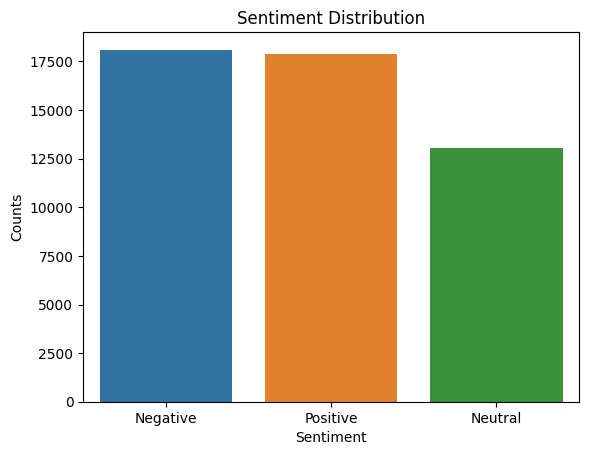

In [29]:
# Assuming 'sentiment_counts' is your Series with sentiment counts
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.ylabel('Counts')
plt.xlabel('Sentiment')
plt.show()

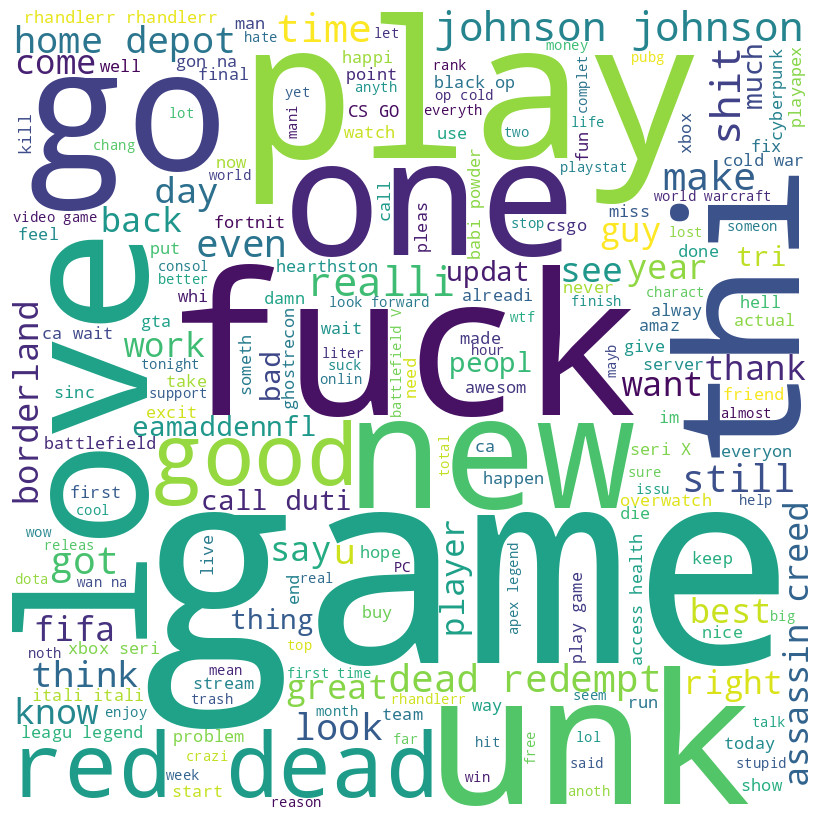

In [31]:
# Assuming 'all_words' is a list of all words in your processed text
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(' '.join(all_words))

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [32]:
df_sentiment

,EntryId,GameName,Sentiment,Text,Processed_Text
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,","[I, come, border, I, kill]"
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,","[im, get, borderland, kill]"
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,","[im, come, borderland, murder]"
3,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,","[im, get, borderland, murder]"
4,2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,","[im, get, borderland, murder]"
...,...,...,...,...,...
72378,11200,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point ift.tt / 36QWteH,"[tom, clanci, ghost, recon, choke, point]"
72379,11200,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point i.tt / 36QWteH,"[tom, clanci, ghost, recon, choke, point]"
72380,11200,TomClancysGhostRecon,Neutral,Tom lin Ghost Recon: Choke Point ift.tt/36QWteH,"[tom, lin, ghost, recon, choke, point]"
72381,11200,TomClancysGhostRecon,Neutral,In Tom Clancy'A s The Ghost House Recon : Choke Point ift. tt / 36QWteH,"[In, tom, the, ghost, hous, recon, choke, point, ift, tt]"


In [33]:
from collections import defaultdict, Counter

# Initialize dictionaries to store word counts for each sentiment
positive_words = defaultdict(int)
negative_words = defaultdict(int)
neutral_words = defaultdict(int)

# Iterate over the DataFrame and update the counts
for _, row in df_sentiment.iterrows():
    sentiment = row['Sentiment']
    for word in row['Processed_Text']:
        if sentiment == 'Positive':
            positive_words[word] += 1
        elif sentiment == 'Negative':
            negative_words[word] += 1
        elif sentiment == 'Neutral':
            neutral_words[word] += 1
            
# Now, find the most common words for each sentiment
most_common_positive = Counter(positive_words).most_common(30)
most_common_negative = Counter(negative_words).most_common(30)
most_common_neutral = Counter(neutral_words).most_common(30)

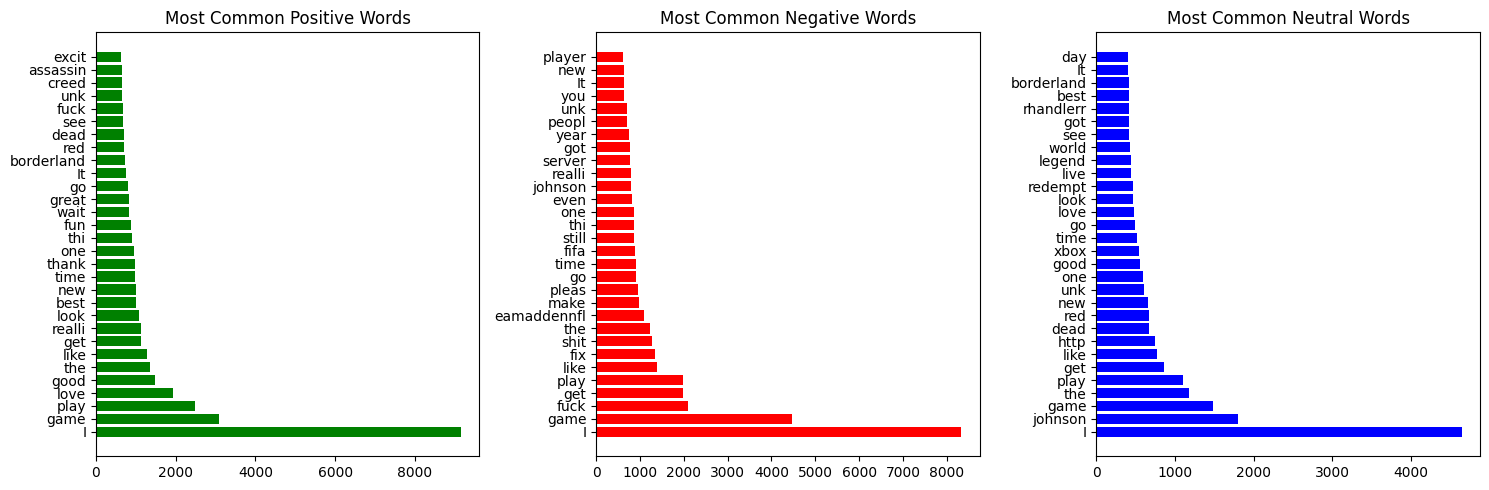

In [34]:
import matplotlib.pyplot as plt

# Function to plot a horizontal bar chart for sentiment words
def plot_most_common_words(most_common, title, ax, color):
    words, counts = zip(*most_common)
    ax.barh(words, counts, color=color)
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting each sentiment
plot_most_common_words(most_common_positive, 'Most Common Positive Words', axes[0], 'green')
plot_most_common_words(most_common_negative, 'Most Common Negative Words', axes[1], 'red')
plot_most_common_words(most_common_neutral, 'Most Common Neutral Words', axes[2], 'blue')

plt.tight_layout()
plt.show()

In [35]:
# Printing the two most common words for each sentiment
print("Two Most Common Positive Words:", most_common_positive[:2])
print("Two Most Common Negative Words:", most_common_negative[:2])
print("Two Most Common Neutral Words:", most_common_neutral[:2])

Two Most Common Positive Words: [('I', 9159), ('game', 3079)]
Two Most Common Negative Words: [('I', 8336), ('game', 4460)]
Two Most Common Neutral Words: [('I', 4650), ('johnson', 1804)]


# **Encoding and cleaning**

In [36]:
# Initialize the label encoder
game_name_encoder = LabelEncoder()

# Fit and transform the GameName column
df_sentiment['GameName_Encoded'] = game_name_encoder.fit_transform(df_sentiment['GameName'])

# Get the mapping of game names to encoded numbers
game_name_mapping = dict(zip(game_name_encoder.classes_, game_name_encoder.transform(game_name_encoder.classes_)))

print("Game Name to Number Mapping:")
print(game_name_mapping)


Game Name to Number Mapping:
{'ApexLegends': 0, 'AssassinsCreed': 1, 'Battlefield': 2, 'Borderlands': 3, 'CS-GO': 4, 'CallOfDuty': 5, 'CallOfDutyBlackopsColdWar': 6, 'Cyberpunk2077': 7, 'Dota2': 8, 'FIFA': 9, 'Fortnite': 10, 'GrandTheftAuto(GTA)': 11, 'Hearthstone': 12, 'HomeDepot': 13, 'LeagueOfLegends': 14, 'MaddenNFL': 15, 'NBA2K': 16, 'Overwatch': 17, 'PlayStation5(PS5)': 18, 'PlayerUnknownsBattlegrounds(PUBG)': 19, 'RedDeadRedemption(RDR)': 20, 'TomClancysGhostRecon': 21, 'TomClancysRainbowSix': 22, 'WorldOfCraft': 23, 'Xbox(Xseries)': 24, 'johnson&johnson': 25}


In [37]:
# Initialize another label encoder for Sentiment
sentiment_encoder = LabelEncoder()

# Fit and transform the Sentiment column
df_sentiment['Sentiment_Encoded'] = sentiment_encoder.fit_transform(df_sentiment['Sentiment'])

# Get the mapping of sentiment labels to encoded numbers
label_mapping = dict(zip(sentiment_encoder.classes_, sentiment_encoder.transform(sentiment_encoder.classes_)))

print("Sentiment to Number Mapping:")
print(label_mapping)

Sentiment to Number Mapping:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join the list of words in Processed_Text into a single string per row
df_sentiment['Processed_Text_Joined'] = df_sentiment['Processed_Text'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the Processed_Text_Joined column
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sentiment['Processed_Text_Joined'])

In [39]:
df_sentiment

,EntryId,GameName,Sentiment,Text,Processed_Text,GameName_Encoded,Sentiment_Encoded,Processed_Text_Joined
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,","[I, come, border, I, kill]",3,2,I come border I kill
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,","[im, get, borderland, kill]",3,2,im get borderland kill
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,","[im, come, borderland, murder]",3,2,im come borderland murder
3,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,","[im, get, borderland, murder]",3,2,im get borderland murder
4,2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,","[im, get, borderland, murder]",3,2,im get borderland murder
...,...,...,...,...,...,...,...,...
72378,11200,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point ift.tt / 36QWteH,"[tom, clanci, ghost, recon, choke, point]",21,1,tom clanci ghost recon choke point
72379,11200,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point i.tt / 36QWteH,"[tom, clanci, ghost, recon, choke, point]",21,1,tom clanci ghost recon choke point
72380,11200,TomClancysGhostRecon,Neutral,Tom lin Ghost Recon: Choke Point ift.tt/36QWteH,"[tom, lin, ghost, recon, choke, point]",21,1,tom lin ghost recon choke point
72381,11200,TomClancysGhostRecon,Neutral,In Tom Clancy'A s The Ghost House Recon : Choke Point ift. tt / 36QWteH,"[In, tom, the, ghost, hous, recon, choke, point, ift, tt]",21,1,In tom the ghost hous recon choke point ift tt


In [41]:
df_sentiment = df_sentiment.drop(columns=['EntryId', 'GameName', 'Sentiment', 'Text', 'Processed_Text', 'Processed_Text_Joined'])


In [42]:
df_sentiment.head()

,GameName_Encoded,Sentiment_Encoded
0,3,2
1,3,2
2,3,2
3,3,2
4,3,2


# **5. Naives Bayes Model**

In [43]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Combine the TF-IDF features with the encoded GameName and Sentiment
X = hstack((tfidf_matrix, df_sentiment[['GameName_Encoded', 'Sentiment_Encoded']].values))
y = df_sentiment['Sentiment_Encoded']  # assuming you want to predict Sentiment

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = nb_classifier.predict(X_test)

# **6. Results**

In [44]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, predictions)))

Model accuracy score: 0.8982


In [45]:
# Evaluate model accuracy on the test set
print('Test-set accuracy score: {0:0.4f}'.format(accuracy_score(y_test, predictions)))

# Make predictions on the training set
y_pred_train = nb_classifier.predict(X_train)

# Evaluate model accuracy on the training set
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Test-set accuracy score: 0.8982
Training-set accuracy score: 0.9209


In [46]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)

print('Confusion matrix\n\n', cm)

# For multiclass, we have to consider each class separately.
print('\nMetrics for Class 0 (Neutral):')
print('True Positives:', cm[0, 0])
print('True Negatives:', cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2])
print('False Positives:', cm[0, 1] + cm[0, 2])
print('False Negatives:', cm[1, 0] + cm[2, 0])

print('\nMetrics for Class 1 (Negative):')
print('True Positives:', cm[1, 1])
print('True Negatives:', cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2])
print('False Positives:', cm[1, 0] + cm[1, 2])
print('False Negatives:', cm[0, 1] + cm[2, 1])


print('\nMetrics for Class 2 (Positive):')
print('True Positives:', cm[2, 2])
print('True Negatives:', cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print('False Positives:', cm[2, 0] + cm[2, 1])
print('False Negatives:', cm[0, 2] + cm[1, 2])

Confusion matrix

 [[5360   23   67]
 [   0 2737 1232]
 [   0  175 5118]]

Metrics for Class 0 (Neutral):
True Positives: 5360
True Negatives: 9262
False Positives: 90
False Negatives: 0

Metrics for Class 1 (Negative):
True Positives: 2737
True Negatives: 10545
False Positives: 1232
False Negatives: 198

Metrics for Class 2 (Positive):
True Positives: 5118
True Negatives: 8120
False Positives: 175
False Negatives: 1299


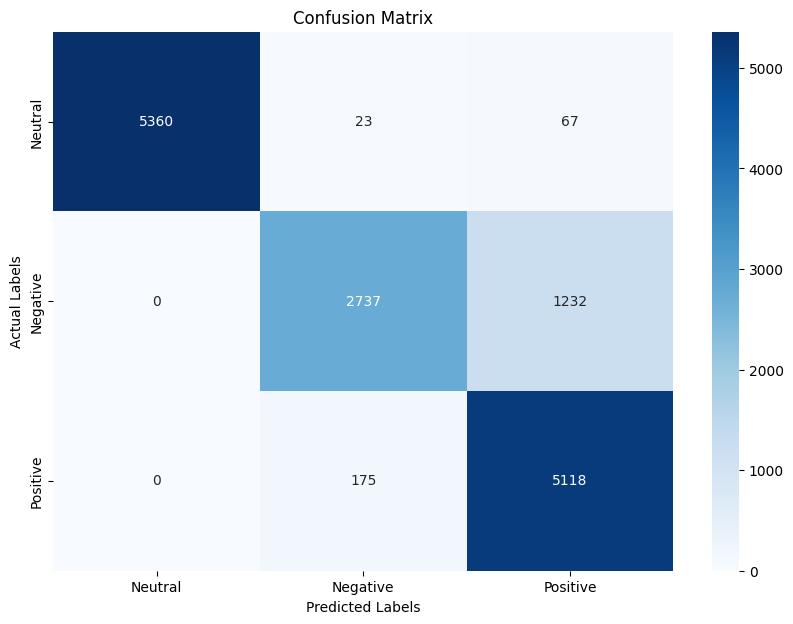

In [47]:
# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()